 # Classification

Dependencies are included in requirements.txt

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter

In [2]:
# Check Device configuration
device = torch.device("cpu")
if torch.backends.mps.is_available():
    device = torch.device("mps")
    x = torch.ones(1, device=device)
    print(x)
elif torch.cuda.is_available():
    device = torch.device("cuda")
    x = torch.ones(1, device=device)
    print(x)

# Define Hyper-parameters
num_classes = 10
num_epochs = 20
batch_size = 32
learning_rate = 0.01

tensor([1.], device='cuda:0')


## Loading and normalizing CIFAR10

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset_cifar10 = torchvision.datasets.CIFAR10(root='./data_cifar10', train=True,
                                        download=True, transform=transform)
trainloader_cifar10 = torch.utils.data.DataLoader(trainset_cifar10, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset_cifar10 = torchvision.datasets.CIFAR10(root='./data_cifar10', train=False,
                                       download=True, transform=transform)
testloader_cifar10 = torch.utils.data.DataLoader(testset_cifar10, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


## Loading and normalizing MINIST

In [4]:
trainset_minist = torchvision.datasets.MNIST(root='./data_minist', train=True,
                                        download=True, transform=transforms.ToTensor())
trainloader_minist = torch.utils.data.DataLoader(trainset_minist, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset_minist = torchvision.datasets.MNIST(root='./data_minist', train=False,
                                       download=True, transform=transforms.ToTensor())
testloader_minist = torch.utils.data.DataLoader(testset_minist, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

In [5]:
classes_cifar10 = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
classes_minist = ('zero', 'one', 'two', 'three',
           'four', 'five', 'six', 'seven', 'eight', 'nine')

## Test Visualization

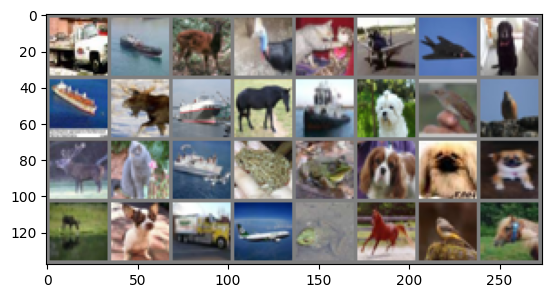

truck ship  deer  bird  cat   plane plane dog   ship  deer  ship  horse ship  dog   bird  bird  deer  cat   ship  frog  frog  dog   dog   dog   deer  dog   truck plane frog  horse bird  horse


In [6]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
  img = (img/2) + 0.5
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

dataiter_cifar10 = iter(trainloader_cifar10)
images_cifar10, labels_cifar10 = next(dataiter_cifar10)

imshow(torchvision.utils.make_grid(images_cifar10))
print(' '.join(f'{classes_cifar10[labels_cifar10[j]]:5s}' for j in range(batch_size)))

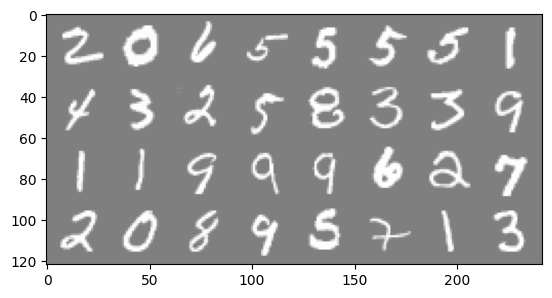

two   zero  six   five  five  five  five  one   four  three two   five  eight three three nine  one   one   nine  nine  nine  six   two   seven two   zero  eight nine  five  seven one   three


In [7]:
dataiter_minist = iter(trainloader_minist)
images_minist, labels_minist = next(dataiter_minist)

imshow(torchvision.utils.make_grid(images_minist))
print(' '.join(f'{classes_minist[labels_minist[j]]:5s}' for j in range(batch_size)))

## Networks

### Network #1: 4 Layers
    a. Layer 1 - convolution with 16 filters, each filter 5x5 with same padding
    b. Layer 2 - ReLU activation
    c. Layer 3 - Flatten layer
    d. Layer 4 - fully connected layer with 10 neurons as output (using cross entropy loss does the softmax)

Since there is some difference between MNIST and CIFAR10 like their number of channels as well as their image dimensions, I will make models that will work with both by having the number of channels and dimensions being passed to it depending on if you are using MNIST or CIFAR10.

In [8]:
class CNNModel1(nn.Module):
  def __init__(self, dims, channels):
    super().__init__()
    self.conv1 = nn.Conv2d(channels,16,5,padding='same')
    self.relu = nn.ReLU()
    self.flatten = nn.Flatten()
    self.fc = nn.Linear(16 * dims**2, 10)

  def forward(self,x):
    out = self.conv1(x)
    out = self.relu(out)
    out = self.flatten(out)
    out = self.fc(out)
    return out

## Network #2: 8-layer network
    a. Layer 1 – convolution with 6 filters , each filter 5x5 with same padding
    b. Layer 2 – ReLU activation
    c. Layer 3 – convolution with 16 filters , each filter 5x5 with same padding
    d. Layer 4 – ReLU activation
    e. Layer 5 – flatten layer
    f. Leyer 6 – fully connected layer with 84 neurons as ouput
    g. Layer 7 – ReLU activation
    h. Layer 8 - fully connected layer with 10 neurons as output (using cross entropy loss
    does the softmax) 

In [9]:
class CNNModel2(nn.Module):
  def __init__(self, dims, channels):
    super().__init__()
    self.conv1 = nn.Conv2d(channels,6,5,padding='same')
    self.relu = nn.ReLU()
    self.conv2 = nn.Conv2d(6,16,5,padding='same')
    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(16 * dims**2, 84)
    self.fc2 = nn.Linear(84, 10)

  def forward(self,x):
    out = self.conv1(x)
    out = self.relu(out)
    out = self.conv2(out)
    out = self.relu(out)
    out = self.flatten(out)
    out = self.fc1(out)
    out = self.relu(out)
    out = self.fc2(out)
    return out

## Network #3: 14-layer network
    a. Layer 1 – convolution with 6 filters , each filter 5x5 with same padding
    b. Layer 2 – batch normalization for 6 filters
    c. Layer 3 – ReLU activation
    d. Layer 4 – Max pooling of size 2 (to halve de image)
    e. Layer 5 – convolution with 16 filters , each filter 5x5 with same padding
    f. Layer 6 – batch normalization for 16 filters
    g. Layer 7 – ReLU activation
    h. Layer 8 – Max pooling of size 2 (to halve de image)
    i. Layer 9 – flatten layer
    j. Leyer 10 – fully connected layer with 120 neurons as ouput
    k. Layer 11 – ReLU activation
    l. Leyer 12 – fully connected layer with 84 neurons as ouput
    m. Layer 13 – ReLU activation
    n. Layer 14 - fully connected layer with 10 neurons as output (using cross entropy loss does the softmax) 

In [10]:
class CNNModel3(nn.Module):
  def __init__(self, dims, channels):
    super().__init__()
    self.conv1 = nn.Conv2d(channels,6,5,padding='same')
    self.batchnorm1 = nn.BatchNorm2d(6)
    self.relu = nn.ReLU()
    self.maxpool = nn.MaxPool2d(2)
    self.conv2 = nn.Conv2d(6,16,5,padding='same')
    self.batchnorm2 = nn.BatchNorm2d(16)
    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(dims**2, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self,x):
    out = self.conv1(x)
    out = self.batchnorm1(out)
    out = self.relu(out)
    out = self.maxpool(out)
    out = self.conv2(out)
    out = self.batchnorm2(out)
    out = self.relu(out)
    out = self.maxpool(out)
    out = self.flatten(out)
    out = self.fc1(out)
    out = self.relu(out)
    out = self.fc2(out)
    out = self.relu(out)
    out = self.fc3(out)
    return out

## Bonus Network
Build your network with more than convolutional and fully connected
layers. Use a filter of size 3x3 to ensure that more convolutional layer can be added. 

In [36]:
class CNNBonus(nn.Module):
  def __init__(self, dims, channels):
    super().__init__()
    self.conv1 = nn.Conv2d(channels,6,3,padding='same')
    self.batchnorm1 = nn.BatchNorm2d(6)
    self.relu = nn.ReLU()
    self.maxpool = nn.MaxPool2d(2)
    self.conv2 = nn.Conv2d(6,16,3,padding='same')
    self.batchnorm2 = nn.BatchNorm2d(16)
    self.conv3 = nn.Conv2d(16,32,3,padding='same')
    self.batchnorm3 = nn.BatchNorm2d(32)
    self.conv4 = nn.Conv2d(32,64,3,padding='same')
    self.batchnorm4 = nn.BatchNorm2d(64)
    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(4 * dims**2, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84,10)

  def forward(self,x):
    out = self.conv1(x)
    out = self.batchnorm1(out)
    out = self.relu(out)
    out = self.maxpool(out)
    out = self.conv2(out)
    out = self.batchnorm2(out)
    out = self.relu(out)
    out = self.conv3(out)
    out = self.batchnorm3(out)
    out = self.relu(out)
    out = self.conv4(out)
    out = self.batchnorm4(out)
    out = self.relu(out)
    out = self.maxpool(out)
    out = self.flatten(out)
    out = self.fc1(out)
    out = self.relu(out)
    out = self.fc2(out)
    out = self.relu(out)
    out = self.fc3(out)
    return out


In [37]:
model1_minist = CNNModel1(28, 1).to(device)
model2_minist = CNNModel2(28, 1).to(device)
model3_minist = CNNModel3(28, 1).to(device)
model_bonus_minist = CNNBonus(28, 1).to(device)
model1_cifar10 = CNNModel1(32, 3).to(device)
model2_cifar10 = CNNModel2(32, 3).to(device)
model3_cifar10 = CNNModel3(32, 3).to(device)
model_bonus_cifar10 = CNNBonus(32, 3).to(device)

In [13]:
criterion = nn.CrossEntropyLoss()

In [14]:
def model_training_cifar10(model):
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    total_step = len(trainloader_cifar10)
    losses = []
    for epoch in range(num_epochs):
        count = 0
        total_loss = 0
        for i, (images, labels) in enumerate(trainloader_cifar10):
            images = images.reshape(-1, 3, 32, 32).to(device)
            labels = labels.to(device)
        
            outputs = model(images)
            loss = criterion(outputs, labels)
        
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            count += 1
            total_loss += loss.item()
        
            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
        losses.append(total_loss/count)
    return losses

In [15]:
def model_training_minist(model):
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    total_step = len(trainloader_minist)
    losses = []
    for epoch in range(num_epochs):
        count = 0
        total_loss = 0
        for i, (images, labels) in enumerate(trainloader_minist):
            images = images.reshape(-1, 1, 28, 28).to(device)
            labels = labels.to(device)
        
            outputs = model(images)
            loss = criterion(outputs, labels)
        
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            count += 1
            total_loss += loss.item()
        
            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
        losses.append(total_loss/count)
    return losses

In [16]:
def model_validation_cifar10(model):
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in testloader_cifar10:
            images = images.reshape(-1, 3, 32, 32).to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        print('Accuracy of the CIFAR10 model on the test images: {} %'.format(100 * correct / total))

In [17]:
def model_validation_minist(model):
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in testloader_minist:
            images = images.reshape(-1, 1, 28, 28).to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        print('Accuracy of the MINIST model on the test images: {} %'.format(100 * correct / total))

In [18]:
def summary_writer(losses, model_name):
    writer = SummaryWriter()
    for i, loss in enumerate(losses):
        writer.add_scalar(f'Loss/{model_name}', loss, i)
    writer.close()

## MINIST Model #1 Training & Testing

In [19]:
print("MINIST Model #1 Training\n------------------")
losses = model_training_minist(model1_minist)
print("--------------------------------")

print("MINIST Model #1 Testing\n------------------")
model_validation_minist(model1_minist)
print("--------------------------------")

summary_writer(losses, "MINIST_Model1")

MINIST Model #1 Training
------------------
Epoch [1/20], Step [100/1875], Loss: 0.6277
Epoch [1/20], Step [200/1875], Loss: 0.3529
Epoch [1/20], Step [300/1875], Loss: 0.5469
Epoch [1/20], Step [400/1875], Loss: 0.4576
Epoch [1/20], Step [500/1875], Loss: 0.8334
Epoch [1/20], Step [600/1875], Loss: 0.1793
Epoch [1/20], Step [700/1875], Loss: 0.2834
Epoch [1/20], Step [800/1875], Loss: 0.2671
Epoch [1/20], Step [900/1875], Loss: 0.2126
Epoch [1/20], Step [1000/1875], Loss: 0.4087
Epoch [1/20], Step [1100/1875], Loss: 0.4265
Epoch [1/20], Step [1200/1875], Loss: 0.5986
Epoch [1/20], Step [1300/1875], Loss: 0.7389
Epoch [1/20], Step [1400/1875], Loss: 0.2409
Epoch [1/20], Step [1500/1875], Loss: 0.2396
Epoch [1/20], Step [1600/1875], Loss: 0.0624
Epoch [1/20], Step [1700/1875], Loss: 0.3233
Epoch [1/20], Step [1800/1875], Loss: 0.2373
Epoch [2/20], Step [100/1875], Loss: 0.4410
Epoch [2/20], Step [200/1875], Loss: 0.4035
Epoch [2/20], Step [300/1875], Loss: 0.2286
Epoch [2/20], Step [400

## MINIST Model #2 Training & Testing

In [20]:
print("MINIST Model #2 Training\n------------------")
losses = model_training_minist(model2_minist)
print("--------------------------------")

print("MINIST Model #2 Testing\n------------------")
model_validation_minist(model2_minist)
print("--------------------------------")

summary_writer(losses, "MINIST_Model2")

MINIST Model #2 Training
------------------
Epoch [1/20], Step [100/1875], Loss: 1.7095
Epoch [1/20], Step [200/1875], Loss: 0.3641
Epoch [1/20], Step [300/1875], Loss: 0.4890
Epoch [1/20], Step [400/1875], Loss: 0.5541
Epoch [1/20], Step [500/1875], Loss: 0.2599
Epoch [1/20], Step [600/1875], Loss: 0.1266
Epoch [1/20], Step [700/1875], Loss: 0.3436
Epoch [1/20], Step [800/1875], Loss: 0.2296
Epoch [1/20], Step [900/1875], Loss: 0.4041
Epoch [1/20], Step [1000/1875], Loss: 0.1106
Epoch [1/20], Step [1100/1875], Loss: 0.0751
Epoch [1/20], Step [1200/1875], Loss: 0.9474
Epoch [1/20], Step [1300/1875], Loss: 0.2121
Epoch [1/20], Step [1400/1875], Loss: 0.1793
Epoch [1/20], Step [1500/1875], Loss: 0.1200
Epoch [1/20], Step [1600/1875], Loss: 0.0604
Epoch [1/20], Step [1700/1875], Loss: 0.2002
Epoch [1/20], Step [1800/1875], Loss: 0.2422
Epoch [2/20], Step [100/1875], Loss: 0.0330
Epoch [2/20], Step [200/1875], Loss: 0.1530
Epoch [2/20], Step [300/1875], Loss: 0.0903
Epoch [2/20], Step [400

## MINIST Model #3 Training & Testing

In [21]:
print("MINIST Model #3 Training\n------------------")
losses = model_training_minist(model3_minist)
print("--------------------------------")

print("MINIST Model #3 Testing\n------------------")
model_validation_minist(model3_minist)
print("--------------------------------")

summary_writer(losses, "MINIST_Model3")

MINIST Model #3 Training
------------------
Epoch [1/20], Step [100/1875], Loss: 1.8806
Epoch [1/20], Step [200/1875], Loss: 1.1155
Epoch [1/20], Step [300/1875], Loss: 0.5292
Epoch [1/20], Step [400/1875], Loss: 0.2378
Epoch [1/20], Step [500/1875], Loss: 0.4090
Epoch [1/20], Step [600/1875], Loss: 0.2483
Epoch [1/20], Step [700/1875], Loss: 0.5346
Epoch [1/20], Step [800/1875], Loss: 0.2188
Epoch [1/20], Step [900/1875], Loss: 0.2560
Epoch [1/20], Step [1000/1875], Loss: 0.0565
Epoch [1/20], Step [1100/1875], Loss: 0.2322
Epoch [1/20], Step [1200/1875], Loss: 0.0758
Epoch [1/20], Step [1300/1875], Loss: 0.1047
Epoch [1/20], Step [1400/1875], Loss: 0.1792
Epoch [1/20], Step [1500/1875], Loss: 0.1518
Epoch [1/20], Step [1600/1875], Loss: 0.2202
Epoch [1/20], Step [1700/1875], Loss: 0.1323
Epoch [1/20], Step [1800/1875], Loss: 0.1223
Epoch [2/20], Step [100/1875], Loss: 0.0209
Epoch [2/20], Step [200/1875], Loss: 0.0767
Epoch [2/20], Step [300/1875], Loss: 0.1036
Epoch [2/20], Step [400

## MINIST Bonus Model Training & Testing

In [38]:
print("MINIST Model Bonus Training\n------------------")
losses = model_training_minist(model_bonus_minist)
print("--------------------------------")

print("MINIST Model Bonus Testing\n------------------")
model_validation_minist(model_bonus_minist)
print("--------------------------------")

summary_writer(losses, "MINIST_BonusModel")

MINIST Model Bonus Training
------------------
Epoch [1/20], Step [100/1875], Loss: 0.9470
Epoch [1/20], Step [200/1875], Loss: 0.4671
Epoch [1/20], Step [300/1875], Loss: 0.1673
Epoch [1/20], Step [400/1875], Loss: 0.1611
Epoch [1/20], Step [500/1875], Loss: 0.2704
Epoch [1/20], Step [600/1875], Loss: 0.0512
Epoch [1/20], Step [700/1875], Loss: 0.1689
Epoch [1/20], Step [800/1875], Loss: 0.1232
Epoch [1/20], Step [900/1875], Loss: 0.0520
Epoch [1/20], Step [1000/1875], Loss: 0.0384
Epoch [1/20], Step [1100/1875], Loss: 0.0565
Epoch [1/20], Step [1200/1875], Loss: 0.0403
Epoch [1/20], Step [1300/1875], Loss: 0.0137
Epoch [1/20], Step [1400/1875], Loss: 0.0401
Epoch [1/20], Step [1500/1875], Loss: 0.0325
Epoch [1/20], Step [1600/1875], Loss: 0.0234
Epoch [1/20], Step [1700/1875], Loss: 0.0403
Epoch [1/20], Step [1800/1875], Loss: 0.0151
Epoch [2/20], Step [100/1875], Loss: 0.0311
Epoch [2/20], Step [200/1875], Loss: 0.1162
Epoch [2/20], Step [300/1875], Loss: 0.0168
Epoch [2/20], Step [

## CIFAR10 Model #1 Training & Testing

In [39]:
print("CIFAR10 Model #1 Training\n-----------------")
losses = model_training_cifar10(model1_cifar10)
print("---------------------------------")

print("CIFAR10 Model #1 Testing\n-------------------------------")
model_validation_cifar10(model1_cifar10)
print("----------------------------------------")

summary_writer(losses, "CIFAR10_Model1")

CIFAR10 Model #1 Training
-----------------
Epoch [1/20], Step [100/1563], Loss: 1.6652
Epoch [1/20], Step [200/1563], Loss: 1.8624
Epoch [1/20], Step [300/1563], Loss: 1.9556
Epoch [1/20], Step [400/1563], Loss: 1.5236
Epoch [1/20], Step [500/1563], Loss: 1.3641
Epoch [1/20], Step [600/1563], Loss: 1.6718
Epoch [1/20], Step [700/1563], Loss: 1.5213
Epoch [1/20], Step [800/1563], Loss: 1.5447
Epoch [1/20], Step [900/1563], Loss: 1.7032
Epoch [1/20], Step [1000/1563], Loss: 1.4873
Epoch [1/20], Step [1100/1563], Loss: 1.4353
Epoch [1/20], Step [1200/1563], Loss: 1.8751
Epoch [1/20], Step [1300/1563], Loss: 1.5372
Epoch [1/20], Step [1400/1563], Loss: 1.4347
Epoch [1/20], Step [1500/1563], Loss: 1.3462
Epoch [2/20], Step [100/1563], Loss: 1.4374
Epoch [2/20], Step [200/1563], Loss: 1.4446
Epoch [2/20], Step [300/1563], Loss: 1.2666
Epoch [2/20], Step [400/1563], Loss: 1.5027
Epoch [2/20], Step [500/1563], Loss: 1.6489
Epoch [2/20], Step [600/1563], Loss: 1.6936
Epoch [2/20], Step [700/15

## CIFAR10 Model #2 Training & Testing

In [40]:
print("CIFAR10 Model #2 Training\n-----------------")
losses = model_training_cifar10(model2_cifar10)
print("---------------------------------")

print("CIFAR10 Model #2 Testing\n-------------------------------")
model_validation_cifar10(model2_cifar10)
print("----------------------------------------")

summary_writer(losses, "CIFAR10_Model2")

CIFAR10 Model #2 Training
-----------------
Epoch [1/20], Step [100/1563], Loss: 2.1540
Epoch [1/20], Step [200/1563], Loss: 1.9275
Epoch [1/20], Step [300/1563], Loss: 2.0085
Epoch [1/20], Step [400/1563], Loss: 1.9611
Epoch [1/20], Step [500/1563], Loss: 1.9978
Epoch [1/20], Step [600/1563], Loss: 1.6566
Epoch [1/20], Step [700/1563], Loss: 1.8413
Epoch [1/20], Step [800/1563], Loss: 1.8539
Epoch [1/20], Step [900/1563], Loss: 1.7416
Epoch [1/20], Step [1000/1563], Loss: 1.7645
Epoch [1/20], Step [1100/1563], Loss: 1.4731
Epoch [1/20], Step [1200/1563], Loss: 1.4042
Epoch [1/20], Step [1300/1563], Loss: 1.5332
Epoch [1/20], Step [1400/1563], Loss: 1.4170
Epoch [1/20], Step [1500/1563], Loss: 1.2302
Epoch [2/20], Step [100/1563], Loss: 1.4410
Epoch [2/20], Step [200/1563], Loss: 1.1800
Epoch [2/20], Step [300/1563], Loss: 1.4717
Epoch [2/20], Step [400/1563], Loss: 1.2716
Epoch [2/20], Step [500/1563], Loss: 1.2705
Epoch [2/20], Step [600/1563], Loss: 1.5040
Epoch [2/20], Step [700/15

## CIFAR10 Model #3 Training & Testing

In [41]:
print("CIFAR10 Model #3 Training\n-----------------")
losses = model_training_cifar10(model3_cifar10)
print("---------------------------------")

print("CIFAR10 Model #3 Testing\n-------------------------------")
model_validation_cifar10(model3_cifar10)
print("----------------------------------------")

summary_writer(losses, "CIFAR10_Model3")

CIFAR10 Model #3 Training
-----------------
Epoch [1/20], Step [100/1563], Loss: 2.1721
Epoch [1/20], Step [200/1563], Loss: 2.0359
Epoch [1/20], Step [300/1563], Loss: 1.9080
Epoch [1/20], Step [400/1563], Loss: 1.7088
Epoch [1/20], Step [500/1563], Loss: 1.6935
Epoch [1/20], Step [600/1563], Loss: 1.5707
Epoch [1/20], Step [700/1563], Loss: 1.5044
Epoch [1/20], Step [800/1563], Loss: 1.7512
Epoch [1/20], Step [900/1563], Loss: 1.4724
Epoch [1/20], Step [1000/1563], Loss: 1.0961
Epoch [1/20], Step [1100/1563], Loss: 1.4813
Epoch [1/20], Step [1200/1563], Loss: 1.5612
Epoch [1/20], Step [1300/1563], Loss: 1.0615
Epoch [1/20], Step [1400/1563], Loss: 1.2596
Epoch [1/20], Step [1500/1563], Loss: 1.4139
Epoch [2/20], Step [100/1563], Loss: 1.2824
Epoch [2/20], Step [200/1563], Loss: 1.0291
Epoch [2/20], Step [300/1563], Loss: 1.2383
Epoch [2/20], Step [400/1563], Loss: 1.5283
Epoch [2/20], Step [500/1563], Loss: 1.0345
Epoch [2/20], Step [600/1563], Loss: 1.4488
Epoch [2/20], Step [700/15

## CIFAR10 Bonus Model Training & Testing

In [42]:
print("CIFAR10 Model Bonus Training\n-----------------")
losses = model_training_cifar10(model_bonus_cifar10)
print("---------------------------------")

print("CIFAR10 Model Bonus Testing\n-------------------------------")
model_validation_cifar10(model_bonus_cifar10)
print("----------------------------------------")

summary_writer(losses, "CIFAR10_BonusModel")

CIFAR10 Model Bonus Training
-----------------
Epoch [1/20], Step [100/1563], Loss: 1.9806
Epoch [1/20], Step [200/1563], Loss: 1.7434
Epoch [1/20], Step [300/1563], Loss: 1.7596
Epoch [1/20], Step [400/1563], Loss: 1.5913
Epoch [1/20], Step [500/1563], Loss: 1.5806
Epoch [1/20], Step [600/1563], Loss: 1.3282
Epoch [1/20], Step [700/1563], Loss: 1.2849
Epoch [1/20], Step [800/1563], Loss: 1.6292
Epoch [1/20], Step [900/1563], Loss: 1.4325
Epoch [1/20], Step [1000/1563], Loss: 1.4200
Epoch [1/20], Step [1100/1563], Loss: 1.2913
Epoch [1/20], Step [1200/1563], Loss: 1.4314
Epoch [1/20], Step [1300/1563], Loss: 1.3523
Epoch [1/20], Step [1400/1563], Loss: 1.3858
Epoch [1/20], Step [1500/1563], Loss: 1.4284
Epoch [2/20], Step [100/1563], Loss: 1.6492
Epoch [2/20], Step [200/1563], Loss: 1.3349
Epoch [2/20], Step [300/1563], Loss: 1.4882
Epoch [2/20], Step [400/1563], Loss: 1.0423
Epoch [2/20], Step [500/1563], Loss: 1.2489
Epoch [2/20], Step [600/1563], Loss: 1.2183
Epoch [2/20], Step [700

### Which of the models had the least amount of error for validation?
For the MINIST models, out of the original 3 models, Model 3 had the least amount of error for validation, with an accuracy of 98.99%. However, the Bonus Model had even less amount of error, reaching an accuracy of 99.22%. Model 2 had less of a loss value, with 0.0062 compared to Model 3's 0.0112, but the Bonus Model had the lowest at 0.0018. Every Model had over a 98% accuracy. 

Compared to MINIST models, the CIFAR10 models were far less accurate. However, similar to the MINIST models, for the CIFAR10 models, out of the original 3 models, Model 3 had the least amount of error for validation, with an accuracy of 68.16%. However, the Bonus Model had even less amount of error, reaching an accuracy of 72.08%. Model 2 had less of a loss value, with 0.0427 compared to Model 3's 0.4621 and the Bonus Model's 0.0.1332. Every Model had over a 60% accuracy. 

### How long it took to train each model?
For MINIST, each model took around 6-7 mins to train.
For CIFAR10, each model took around 10 mins to train on average.
This training was done on VSCode on my computer, and it was using the cuda device.